# 10. Supervised Machine Learning Techniques Assignment II 
-- Chuying Tang

In this report, we will use H2O module in Python to build (1) the GLM model and (2) the  autoML with the mortgage probability of default data. The criteria for the models include ROC and the cumulative Lift. For GLM model, we will use grid search to tune the hyper-parameters and improve the model's performance.



# Table of Contents <a class="anchor" id="0"></a>
- <b>[1. Data Preparation](#1)</b>
- <b>[2. H2O Introduction](#2)</b>
- <b>[3. Sample Model & Metrics Functions](#3)</b>
- <b>[4. GLM (Generalized Linear Model) Model](#4)</b>
- <b>[5. Auto Machine Learning](#5)</b>
- <b>[6. Conclusion](#6)</b>

       
  <p>&nbsp;</p>

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation <a class="anchor" id="1"></a>

In [2]:
# load data
path = '/Users/mac/Downloads/' 
data = pd.read_csv(path + 'XYZloan_default_selected_vars.csv')  
# data = pd.read_csv('XYZloan_default_selected_vars.csv') 
data.tail()

,Unnamed: 0.1,Unnamed: 0,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
79995,79995,79996,79996,0,39,2,1,12,2017/5/7 13:44,android,...,15.0,8.0,864.0,684.0,1261.0,764.0,2600.0,1074.0,11.0,OPPO
79996,79996,79997,79997,0,31,1,4,12,2017/6/2 15:54,ios,...,25.0,25.0,6177.0,6177.0,6426.0,6426.0,6426.0,6426.0,6.0,IPHONE7
79997,79997,79998,79998,0,37,1,1,12,2017/7/9 8:40,android,...,14.0,13.0,1116.0,1116.0,2061.0,2061.0,2501.0,2061.0,12.0,VIVO
79998,79998,79999,79999,0,38,2,1,12,2017/5/9 10:19,android,...,5.0,2.0,25.0,0.0,498.0,343.0,514.0,343.0,6.0,XIAOMI
79999,79999,80000,80000,1,25,1,3,12,2017/4/27 18:36,h5,...,9.0,9.0,129.0,129.0,167.0,167.0,167.0,167.0,7.0,WEB


In [3]:
# split the data for modeling
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42) 

In [4]:
train.shape

(64000, 89)

In [5]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [6]:
# change the colum names of var dataframe
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [7]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [8]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [9]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [10]:
train['loan_default'].value_counts(dropna=False)

0    51662
1    12338
Name: loan_default, dtype: int64

In [11]:
target='loan_default'
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

## 2. H2O Introduction <a class="anchor" id="2"></a>

In [12]:
# !pip install h2o

In [13]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "19" 2022-09-20; Java(TM) SE Runtime Environment (build 19+36-2238); Java HotSpot(TM) 64-Bit Server VM (build 19+36-2238, mixed mode, sharing)
  Starting server from /Users/mac/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpigigkvl3
  JVM stdout: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpigigkvl3/h2o_mac_started_from_python.out
  JVM stderr: /var/folders/6y/dd1qh2x900v5tw238ssc4psw0000gn/T/tmpigigkvl3/h2o_mac_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,"28 days, 19 hours and 19 minutes"
H2O_cluster_name:,H2O_from_python_mac_azljgx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [14]:
h2o.connect()

Connecting to H2O server at http://localhost:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,"28 days, 19 hours and 19 minutes"
H2O_cluster_name:,H2O_from_python_mac_azljgx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


<H2OConnection to http://localhost:54321, no session>

## 3. Sample Model & Metrics Functions <a class="anchor" id="3"></a>

In [15]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [16]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "binomial", lambda_ = 0.05) #, compute_p_values = True)
glm_v1.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1666099839017_1


GLM Model: summary
    family    link    regularization                             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -----------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.05 )  78                            7                              4                       Key_Frame__upload_a11730e34cfe232ec68b0a2690704217.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1503262429539389
RMSE: 0.38771928370141573
LogLoss: 0.4753812321607154
AUC: 0.6266288704795239
AUCPR: 0.2742113377527716
Gini: 0.25325774095904774
Null degrees of freedom: 6399
Residual degrees of freedom: 6392
Null deviance: 6209.12843748778
Residual deviance: 6084.879771657157
AIC: 6100.879771657157

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1828495213563142
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      2822  2367  0.4562   (2367.0/5189.0)
1      427   784   0.3526   (427.0/1211.0)
Total  3249  3151  0.4366   (2794.0/6400.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.18285      0.359468  281
max f2                       0.160906     0.547082  363
max f0point5                 0.202994     0.30326   204
max accuracy                 0.373314     0.811094  1
max precision                0.419642     1         0
max recall                   0.146852     1         392
max specificity              0.419642     1         0
max absolute_mcc             0.186199     0.150488  265
max min_per_class_accuracy   0.185941     0.594141  266
max mean_per_class_accuracy  0.183643     0.595746  277
max tns                      0.419642     5189      0
max fns                      0.419642     1210      0
max fps                      0.134632     5189      399
max tps                      0.146852     1211      392
max tnr                      0.419642     1         0
max fnr                      0.419642     0.999174  0
max fpr                      0.134632     1         399
max tpr                      0.146852     1         392

Gains/Lift Table: Avg response rate: 18.92 %, avg score: 18.92 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.284243           1.81668   1.81668            0.34375          0.307385  0.34375                     0.307385            0.0181668       0.0181668                  81.668    81.668             0.0100728
2        0.02                        0.269639           2.06441   1.94055            0.390625         0.276848  0.367188                    0.292117            0.0206441       0.0388109                  106.441   94.0545            0.023201
3        0.03                        0.258872           1.98183   1.95431            0.375            0.264286  0.369792                    0.28284             0.0198183       0.0586292                  98.1833   95.4308            0.0353107
4        0.04                        0.252382           1.65153   1.87861            0.3125           0.255491  0.355469                    0.276002    

In [18]:
predictions = glm_v1.predict(test_hex)['p1']
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,p1
0,0,0.220752
1,0,0.212520
2,0,0.220526
3,0,0.165042
4,0,0.193705


Here we define functions to generate gains table and ROC/AUC. We will first use a portion of dataset to validate that our self defined functions are application. We will then apply the functions to the whole dataset. 

### Gains Table
A Gains Chart can serve two great purposes to help our business strategies: (i) selecting the better-performing model, and (ii) deciding which segments to target. In this case, we will use it to select the better-performing model to detect the loan faults.

In [19]:
# define a function to conduct gains table
def createGains(model):
    predictions = model.predict(test_hex)['p1']
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='p1',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(glm_v1)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,160,52,108,160,52,108,0.17,0.08,30.0,1.73,9.0,32.50
1,160,44,116,320,96,224,0.32,0.17,60.0,1.60,15.0,30.00
2,160,38,122,480,134,346,0.45,0.27,90.0,1.49,18.0,27.92
3,160,39,121,640,173,467,0.58,0.36,120.0,1.44,22.0,27.03
4,160,29,131,800,202,598,0.67,0.46,150.0,1.35,21.0,25.25
5,160,24,136,960,226,734,0.75,0.56,180.0,1.26,19.0,23.54
6,160,26,134,1120,252,868,0.84,0.67,210.0,1.20,17.0,22.50
7,160,17,143,1280,269,1011,0.90,0.78,240.0,1.12,12.0,21.02
8,160,19,141,1440,288,1152,0.96,0.89,270.0,1.07,7.0,20.00


### ROC (Receiver Operating Characteristic) & AUC (Area Under the Curve)
The receiver operating characteristic (ROC) curve is one of the most effective evaluation metrics because it visualizes the accuracy of predictions for a whole range of cutoff values.If we had a perfect model, the ROC curve would pass through the upper left corner — indicating no error. A better model is when the ROC is close to the upper left corner.  
The most important parameter that can be obtained from a ROC curve is the Area Under the Curve (AUC). For a perfect model, the area under the curve would be 1.0.

In [20]:
# define a functiont to calculate ROC_AUC
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df)['p1'].as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



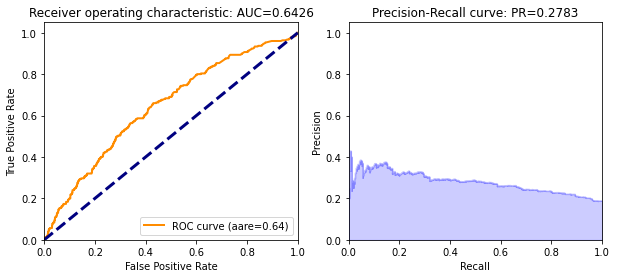

In [21]:
ROC_AUC(glm_v1,test_hex,'loan_default')

Figure above shows that the AUC is 0.6426.

In [22]:
# Print the Coefficients table
coefs = glm_v1._model_json['output']['coefficients_table'].as_data_frame()
coefs = pd.DataFrame(coefs)
coefs.sort_values(by='standardized_coefficients',ascending=False)

,names,coefficients,standardized_coefficients
59,TD013,0.025247,0.129573
57,TD009,0.008633,0.034865
75,PA029,0.000260,0.025146
55,TD005,0.003019,0.008536
77,PA031,0.000037,0.003459
...,...,...,...
24,MB007.NUBIA,0.000000,0.000000
23,MB007.MONEYMAKINGMACHINE,0.000000,0.000000
22,MB007.MEIZU,0.000000,0.000000
49,AP003,-0.050631,-0.060416


In [55]:
data['TD013'].describe()

count    80000.000000
mean         6.804737
std          5.128183
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         52.000000
Name: TD013, dtype: float64

A regression coefficient describes the size and direction of the relationship between a predictor and the response variable. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. From the regression output, we can see that the standardized coefficient for 'TD013' is 0.13. This means that, on average, each additional 'TD013' is associated with an increase of 0.13 probility of loan fault, assuming the other predictor variables are held constant.

#### [Back to the top](#0)

## 4. GLM (Generalized Linear Model) Model <a class="anchor" id="4"></a>
The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.
### 4.1 Basic GLM model

In [23]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

# convert target variable into factor for binary classification
train_hex[target] = train_hex[target].asfactor()
test_hex[target] = test_hex[target].asfactor()

glm_v2 = H2OGeneralizedLinearEstimator(family= "binomial", 
                                       lambda_ = 0.05) #, compute_p_values = True)
glm_v2.train(predictors,target,training_frame=train_hex)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1666099839017_3


GLM Model: summary
    family    link    regularization                             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -----------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.05 )  47282                         4                              4                       py_7_sid_870e

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.15222602571277172
RMSE: 0.39016153797212216
LogLoss: 0.4796703247299019
AUC: 0.628965932965312
AUCPR: 0.27822175392001597
Gini: 0.257931865930624
Null degrees of freedom: 63999
Residual degrees of freedom: 63995
Null deviance: 62749.53823951552
Residual deviance: 61397.80156542744
AIC: 61407.80156542744

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18454706880419008
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      26946  24716  0.4784   (24716.0/51662.0)
1      4131   8207   0.3348   (4131.0/12338.0)
Total  31077  32923  0.4507   (28847.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.184547     0.362652  296
max f2                       0.160576     0.551214  364
max f0point5                 0.20539      0.30522   236
max accuracy                 0.539215     0.807234  0
max precision                0.539215     1         0
max recall                   0.137366     1         397
max specificity              0.539215     1         0
max absolute_mcc             0.195796     0.152094  263
max min_per_class_accuracy   0.189603     0.59206   281
max mean_per_class_accuracy  0.184893     0.593451  295
max tns                      0.539215     51662     0
max fns                      0.539215     12337     0
max fps                      0.130307     51662     399
max tps                      0.137366     12338     397
max tnr                      0.539215     1         0
max fnr                      0.539215     0.999919  0
max fpr                      0.130307     1         399
max tpr                      0.137366     1         397

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.28 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100156                   0.299658           2.03928   2.03928            0.393136         0.329693  0.393136                    0.329693            0.0204247       0.0204247                  103.928   103.928            0.012895
2        0.02                        0.279877           1.81837   1.929              0.350548         0.288542  0.371875                    0.30915             0.0181553       0.03858                    81.837    92.9               0.0230173
3        0.0301094                   0.268253           1.86003   1.90584            0.358578         0.273678  0.36741                     0.29724             0.0188037       0.0573837                  86.0026   90.5841            0.033788
4        0.0400156                   0.260125           2.00453   1.93027            0.386435         0.264127  0.37212                     0.289042            0.0198574       0.077241                   100.453 

In [24]:
createGains(glm_v2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,548,1052,1600,548,1052,0.17,0.08,315.0,1.74,9.0,34.25
1,1600,445,1155,3200,993,2207,0.32,0.17,630.0,1.58,15.0,31.03
2,1600,394,1206,4800,1387,3413,0.44,0.27,945.0,1.47,17.0,28.90
3,1600,363,1237,6400,1750,4650,0.56,0.36,1260.0,1.39,20.0,27.34
4,1600,314,1286,8000,2064,5936,0.66,0.46,1575.0,1.31,20.0,25.80
5,1600,291,1309,9600,2355,7245,0.75,0.56,1890.0,1.25,19.0,24.53
6,1600,267,1333,11200,2622,8578,0.83,0.67,2205.0,1.19,16.0,23.41
7,1600,214,1386,12800,2836,9964,0.90,0.78,2520.0,1.13,12.0,22.16
8,1600,182,1418,14400,3018,11382,0.96,0.89,2835.0,1.06,7.0,20.96


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



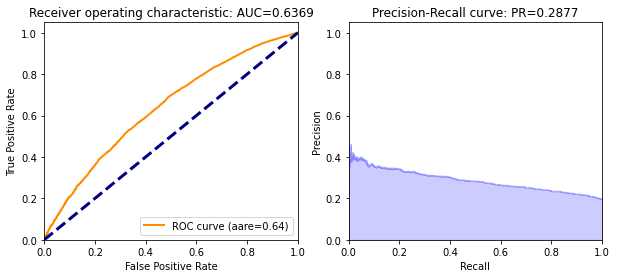

In [25]:
ROC_AUC(glm_v2,test_hex,'loan_default')

The orange curve is the ROC curve. The above plot with 0.6369 ROC means that the model result is slightly better than a completely random draw(blue line).

### 4.2 Hyper-parameter Tunning with Grid Search
To get the best possible model, GLM and GAM need to find the optimal values of the regularization parameters 𝛼 and 𝜆. When performing regularization, penalties are introduced to the model buidling process to avoid overfitting, to reduce variance of the prediction error, and to handle correlated predictors. The two most common penalized models are ridge regression and LASSO (least absolute shrinkage and selection operator). 

### `lambda_` parameter
The lambda parameter controls the amount of regularization applied to the model. A non-negative value represents a shrinkage parameter, which multiplies 𝑃(𝛼,𝛽) in the objective. The larger lambda is, the more the coefficients are shrunk toward zero (and each other). When the value is 0, regularization is disabled, and ordinary generalized liner models are fit.  
Here we assum that the alpha=0 and search for the best lambda value for the model, which can be considered a Ridge Regression model for penalty.

In [26]:
from h2o.grid.grid_search import H2OGridSearch

In [27]:
# select the values for lambda_ to grid over
hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.05, 0.001, 0.0001, 0]}

We use cartesian grid search because the search space is small and we want to see the performance of all models.

In [28]:
# initialize the glm estimator
glm_t1 = H2OGeneralizedLinearEstimator(family = 'binomial')

In [29]:
# build grid search with previously made GLM and hyperparameters
grid_glm1 = H2OGridSearch(model = glm_t1, 
                         hyper_params = hyper_params,
                         search_criteria = {'strategy': "Cartesian"})


In [30]:
# train using the grid
grid_glm1.train(x = predictors, y = target, training_frame = train_hex, validation_frame = test_hex)


glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,lambda,model_ids,logloss
,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_6,0.4698330
,0.0001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_7,0.4698885
,0.01,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_4,0.4711758
,0.05,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_5,0.4846377
,0.1,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_3,0.4942622
,1.0,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_1,0.4960932
,0.5,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_2,0.4960932
,0.0,Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_8,0.5530922


In [31]:
# sort the grid models by decreasing AUC
grid_glm_sorted1 = grid_glm1.get_grid(sort_by = 'auc', decreasing = True)
print(grid_glm_sorted1)

Hyper-Parameter Search Summary: ordered by decreasing auc
    lambda    model_ids                                                    auc
--  --------  -----------------------------------------------------------  --------
    0.001     Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_6  0.665004
    0.0001    Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_7  0.664795
    0.01      Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_4  0.664625
    0.05      Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_5  0.636898
    0         Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_8  0.617578
    0.1       Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_3  0.610742
    1         Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_1  0.5
    0.5       Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_2  0.5


Ranking by the AUC, the best model has a lambda value of 0.001.

In [32]:
# Grab the top GlM model, chosen by validation AUC
glm_gridper1 = grid_glm_sorted1.models[0]
glm_gridper1

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_py_7_sid_870e_model_python_1666099839017_5_model_6


GLM Model: summary
    family    link    regularization                              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.001 )  47282                         34                             3                       py_7_sid_870e

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1476475116577068
RMSE: 0.3842492832234132
LogLoss: 0.46446544552036695
AUC: 0.6633214832468504
AUCPR: 0.3082865888873189
Gini: 0.3266429664937007
Null degrees of freedom: 63999
Residual degrees of freedom: 63965
Null deviance: 62749.53823951552
Residual deviance: 59451.57702660696
AIC: 59521.57702660696

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17714708838711962
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      27937  23725  0.4592   (23725.0/51662.0)
1      3761   8577   0.3048   (3761.0/12338.0)
Total  31698  32302  0.4295   (27486.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.177147     0.384274  260
max f2                       0.118565     0.56271   330
max f0point5                 0.249207     0.337334  183
max accuracy                 0.618552     0.807344  14
max precision                0.667627     0.612903  8
max recall                   0.0337221    1         397
max specificity              0.836148     0.999981  0
max absolute_mcc             0.204583     0.188347  229
max min_per_class_accuracy   0.192436     0.615791  242
max mean_per_class_accuracy  0.177147     0.617967  260
max tns                      0.836148     51661     0
max fns                      0.836148     12337     0
max fps                      0.0206492    51662     399
max tps                      0.0337221    12338     397
max tnr                      0.836148     0.999981  0
max fnr                      0.836148     0.999919  0
max fpr                      0.0206492    1         399
max tpr                      0.0337221    1         397

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.27 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.478261           2.2451    2.2451             0.432812         0.541164  0.432812                    0.541164            0.022451        0.022451                   124.51    124.51             0.0154245
2        0.02                        0.428183           2.35857   2.30183            0.454688         0.450797  0.44375                     0.49598             0.0235857       0.0460366                  135.857   130.183            0.0322547
3        0.03                        0.398843           1.95331   2.18566            0.376563         0.41265   0.421354                    0.468204            0.0195331       0.0655698                  95.3315   118.566            0.0440646
4        0.04                        0.378472           1.95331   2.12757            0.376563         0.388417  0.410156                    0.448257            0.0195331       0.

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



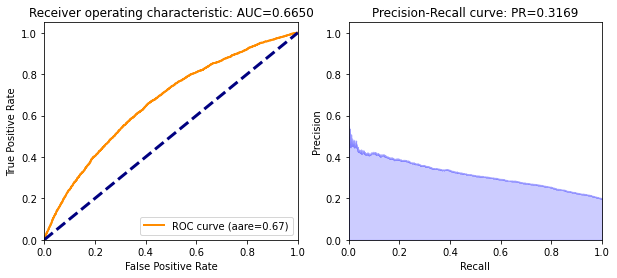

In [33]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
ROC_AUC(glm_gridper1,test_hex,'loan_default')

In [34]:
createGains(glm_gridper1)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,621,979,1600,621,979,0.20,0.08,315.0,1.97,12.0,38.81
1,1600,475,1125,3200,1096,2104,0.35,0.16,630.0,1.74,19.0,34.25
2,1600,408,1192,4800,1504,3296,0.48,0.26,945.0,1.59,22.0,31.33
3,1600,365,1235,6400,1869,4531,0.59,0.35,1260.0,1.48,24.0,29.20
4,1600,318,1282,8000,2187,5813,0.69,0.45,1575.0,1.39,24.0,27.34
5,1600,275,1325,9600,2462,7138,0.78,0.56,1890.0,1.30,22.0,25.65
6,1600,216,1384,11200,2678,8522,0.85,0.66,2205.0,1.21,19.0,23.91
7,1600,176,1424,12800,2854,9946,0.91,0.77,2520.0,1.13,14.0,22.30
8,1600,174,1426,14400,3028,11372,0.96,0.88,2835.0,1.07,8.0,21.03


The AUC is 0.6650, which is higher than that of the model without penalty. That is to say, applying lambda value(0.001) does improve the glm models.

### `alpha` parameter
The alpha parameter controls the distribution between the ℓ1 (LASSO) and ℓ2 (ridge regression) penalties. 

In [35]:
# initialize the estimator then train the model
glm_v3 = H2OGeneralizedLinearEstimator(alpha = .25)
glm_v3.train(x = predictors, 
             y = target, 
             training_frame = train_hex, 
             validation_frame = test_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1666099839017_22


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.25, lambda = 0.02248 )  47282                         22                             4                       py_7_sid_870e

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1484310421423953
RMSE: 0.3852674942717012
LogLoss: 0.4673788631818238
AUC: 0.6593768663739523
AUCPR: 0.3044892449048534
Gini: 0.31875373274790464
Null degrees of freedom: 63999
Residual degrees of freedom: 63977
Null deviance: 62749.53823951552
Residual deviance: 59824.49448727345
AIC: 59870.49448727345

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1900933895407132
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      30974  20688  0.4004   (20688.0/51662.0)
1      4509   7829   0.3655   (4509.0/12338.0)
Total  35483  28517  0.3937   (25197.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.190093     0.383258  242
max f2                       0.134158     0.560157  326
max f0point5                 0.238711     0.333364  178
max accuracy                 0.524877     0.807281  21
max precision                0.614643     0.571429  8
max recall                   0.0610345    1         396
max specificity              0.77348      0.999981  0
max absolute_mcc             0.199736     0.188321  227
max min_per_class_accuracy   0.192581     0.614939  238
max mean_per_class_accuracy  0.190093     0.617047  242
max tns                      0.77348      51661     0
max fns                      0.77348      12338     0
max fps                      0.040028     51662     399
max tps                      0.0610345    12338     396
max tnr                      0.77348      0.999981  0
max fnr                      0.77348      1         0
max fpr                      0.040028     1         399
max tpr                      0.0610345    1         396

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.28 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.416717           2.30994   2.30994            0.445312         0.474621  0.445312                    0.474621            0.0230994       0.0230994                  130.994   130.994            0.0162278
2        0.02                        0.376059           2.05868   2.18431            0.396875         0.394607  0.421094                    0.434614            0.0205868       0.0436862                  105.868   118.431            0.0293429
3        0.03                        0.35239            2.0911    2.15324            0.403125         0.363461  0.415104                    0.410897            0.020911        0.0645972                  109.11    115.324            0.0428597
4        0.04                        0.335171           1.98574   2.11136            0.382812         0.343005  0.407031                    0.393924            0.0198574       0.0844545           

In [36]:
# print the mse for the validation data
print(glm_v3.auc(valid=True))

0.6639965659934531


In [37]:
# grid over `alpha`

# select the values for `alpha` to grid over
hyper_params2 = {'alpha': [0, .1, .25, .5, .75, 1]}

In [38]:
# initialize the GLM estimator
glm_t2 = H2OGeneralizedLinearEstimator()

In [39]:
# build grid search with previously made GLM and hyperparameters
glm_grid2 = H2OGridSearch(model = glm_t2, 
                          hyper_params = hyper_params2,
                          search_criteria = {'strategy': "Cartesian"})

In [40]:
# train using the grid
glm_grid2.train(x = predictors, 
                y = target, 
                training_frame = train_hex, 
                validation_frame = test_hex)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,alpha,model_ids,logloss
,0.0,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_1,0.4700021
,1.0,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_6,0.4711968
,0.75,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_5,0.4713008
,0.5,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_4,0.4715088
,0.25,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_3,0.4721112
,0.1,Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_2,0.4737391


In [56]:
# sort the grid models by mse
glm_grid_sorted2 = glm_grid2.get_grid(sort_by='auc', decreasing=True)
print(glm_grid_sorted2)

Hyper-Parameter Search Summary: ordered by decreasing auc
    alpha    model_ids                                                     auc
--  -------  ------------------------------------------------------------  --------
    0        Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_1  0.664589
    1        Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_6  0.664399
    0.75     Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_5  0.664373
    0.5      Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_4  0.66428
    0.25     Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_3  0.663997
    0.1      Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_2  0.662713


The best model has a alpha value of 0.1. We can pick up the best model and see how it perform on the test data to evaluate its predicability.

In [57]:
# Grab the top GlM model, chosen by validation AUC
glm_gridper2 = glm_grid_sorted2.models[0]
glm_gridper2

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_py_7_sid_870e_model_python_1666099839017_25_model_1


GLM Model: summary
    family    link    regularization               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 0.005621 )  47282                         47282                          10                      py_7_sid_870e

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14761861916580665
RMSE: 0.38421168535822364
LogLoss: 0.4644100695616402
AUC: 0.6635808988521277
AUCPR: 0.30869911822170426
Gini: 0.32716179770425535
Null degrees of freedom: 63999
Residual degrees of freedom: 16717
Null deviance: 62749.53823951552
Residual deviance: 59444.48890388995
AIC: 154010.48890388996

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1800997902484853
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      28535  23127  0.4477   (23127.0/51662.0)
1      3895   8443   0.3157   (3895.0/12338.0)
Total  32430  31570  0.4222   (27022.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.1801       0.384577  254
max f2                       0.118549     0.562653  327
max f0point5                 0.256223     0.337549  174
max accuracy                 0.615488     0.807359  16
max precision                0.675807     0.62069   9
max recall                   0.0334404    1         396
max specificity              0.856404     0.999981  0
max absolute_mcc             0.197348     0.189035  233
max min_per_class_accuracy   0.193857     0.616713  237
max mean_per_class_accuracy  0.1801       0.618324  254
max tns                      0.856404     51661     0
max fns                      0.856404     12337     0
max fps                      0.0139783    51662     399
max tps                      0.0334404    12338     396
max tnr                      0.856404     0.999981  0
max fnr                      0.856404     0.999919  0
max fpr                      0.0139783    1         399
max tpr                      0.0334404    1         396

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.34 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.477427           2.28562   2.28562            0.440625         0.542164   0.440625                    0.542164            0.0228562       0.0228562                  128.562   128.562            0.0159266
2        0.02                        0.426931           2.34236   2.31399            0.451562         0.450405   0.446094                    0.496285            0.0234236       0.0462798                  134.236   131.399            0.032556
3        0.03                        0.399139           1.83984   2.15594            0.354687         0.412498   0.415625                    0.468356            0.0183984       0.0646782                  83.9844   115.594            0.0429601
4        0.04                        0.378041           2.03437   2.12555            0.392188         0.388042   0.409766                    0.448277            0.0203437       0.0850219                  103.437   1

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



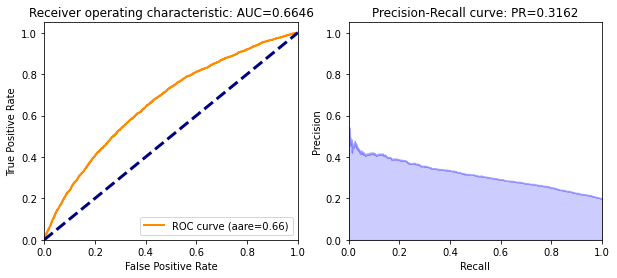

In [58]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
ROC_AUC(glm_gridper2,test_hex,'loan_default')

In [59]:
createGains(glm_gridper2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,617,983,1600,617,983,0.20,0.08,315.0,1.96,12.0,38.56
1,1600,475,1125,3200,1092,2108,0.35,0.16,630.0,1.73,19.0,34.12
2,1600,416,1184,4800,1508,3292,0.48,0.26,945.0,1.60,22.0,31.42
3,1600,360,1240,6400,1868,4532,0.59,0.35,1260.0,1.48,24.0,29.19
4,1600,314,1286,8000,2182,5818,0.69,0.45,1575.0,1.39,24.0,27.28
5,1600,283,1317,9600,2465,7135,0.78,0.56,1890.0,1.30,22.0,25.68
6,1600,202,1398,11200,2667,8533,0.85,0.66,2205.0,1.21,19.0,23.81
7,1600,192,1408,12800,2859,9941,0.91,0.77,2520.0,1.13,14.0,22.34
8,1600,171,1429,14400,3030,11370,0.96,0.88,2835.0,1.07,8.0,21.04


The AUC is 0.6646, which is higher than that of the model without penalty but lower than the model with ridge regression(lambda). Setting Alpha value does improve the glm models.

### Elastic Net Penalty
Elastic net regularization is a combination of the ℓ1 and ℓ2 penalties parametrized by the 𝛼 and 𝜆 arguments (similar to “Regularization Paths for Genarlized Linear Models via Coordinate Descent” by Friedman et all).  
The combination of the ℓ1 and ℓ2 penalties is beneficial because ℓ1 induces sparsity, while ℓ2 gives stability and encourages the grouping effect (where a group of correlated variables tend to be dropped or added into the model simultaneously). When focusing on sparsity, one possible use of the 𝛼 argument involves using the ℓ1 mainly with very little ℓ2 (𝛼 almost 1) to stabilize the computation and improve convergence speed.

In [63]:
# grid over `alpha` and 'lambda'

# select the values for `alpha` and 'lambda' to grid over
hyper_params3 = {'alpha': [0, .1, .25, .5, .75, 1],
                 'lambda': [1, 0.5, 0.1, 0.01, 0.05, 0.001, 0.0001, 0]}

In [64]:
# initialize the GLM estimator
glm_t3 = H2OGeneralizedLinearEstimator()

In [65]:
# build grid search with previously made GLM and hyperparameters
glm_grid3 = H2OGridSearch(model = glm_t3, 
                          hyper_params = hyper_params3,
                          search_criteria = {'strategy': "Cartesian"})

In [66]:
# train using the grid
glm_grid3.train(x = predictors, 
                y = target, 
                training_frame = train_hex, 
                validation_frame = test_hex)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,alpha,lambda,model_ids,logloss
,0.25,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_33,0.4697514
,0.1,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_32,0.4697634
,0.5,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_34,0.4698330
,1.0,0.0001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_42,0.4698376
,0.75,0.0001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_41,0.4698418
,0.5,0.0001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_40,0.4698885
,0.25,0.0001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_39,0.4699136
,0.75,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_35,0.4699409
,1.0,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_36,0.4699443
,0.0,0.001,Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_31,0.4699940


In [67]:
# sort the grid models by mse
glm_grid_sorted3 = glm_grid3.get_grid(sort_by='auc', decreasing=True)
print(glm_grid_sorted3)

Hyper-Parameter Search Summary: ordered by decreasing auc
     alpha    lambda    model_ids                                                       auc
---  -------  --------  --------------------------------------------------------------  ------------------
     0.1      0.01      Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_20  0.6652182076462232
     0.25     0.01      Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_21  0.6651437588783893
     0.25     0.001     Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_33  0.6651431906614786
     0.1      0.001     Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_32  0.6651234760051881
     0.5      0.001     Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_34  0.6650041875115805
     1.0      0.0001    Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_42  0.6649421283429066
     0.75     0.0001    Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_41  0.66490021616

The best model has a alpha value of 0.1 and lambda of 0.01, which is a elastic net regularization. We can pick up the best model and see how it perform on the test data to evaluate its predicability.

In [68]:
# Grab the top GlM model, chosen by validation AUC
glm_gridper3 = glm_grid_sorted3.models[0]
glm_gridper3

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_py_7_sid_870e_model_python_1666099839017_269_model_20


GLM Model: summary
    family    link    regularization                             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -----------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.1, lambda = 0.01 )  47282                         32                             3                       py_7_sid_870e

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14774737187680517
RMSE: 0.38437920323139907
LogLoss: 0.46487222120612964
AUC: 0.6630303296162892
AUCPR: 0.3076860230251172
Gini: 0.3260606592325783
Null degrees of freedom: 63999
Residual degrees of freedom: 63967
Null deviance: 62749.53823951552
Residual deviance: 59503.6443143846
AIC: 59569.6443143846

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19594232698313138
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      32655  19007  0.3679   (19007.0/51662.0)
1      4887   7451   0.3961   (4887.0/12338.0)
Total  37542  26458  0.3733   (23894.0/64000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.195942     0.384112  233
max f2                       0.118502     0.56235   331
max f0point5                 0.244453     0.33657   180
max accuracy                 0.55739      0.807344  23
max precision                0.646502     0.580645  10
max recall                   0.0382043    1         396
max specificity              0.827198     0.999981  0
max absolute_mcc             0.195942     0.189049  233
max min_per_class_accuracy   0.192668     0.616198  237
max mean_per_class_accuracy  0.195942     0.617998  233
max tns                      0.827198     51661     0
max fns                      0.827198     12337     0
max fps                      0.0172448    51662     399
max tps                      0.0382043    12338     396
max tnr                      0.827198     0.999981  0
max fnr                      0.827198     0.999919  0
max fpr                      0.0172448    1         399
max tpr                      0.0382043    1         396

Gains/Lift Table: Avg response rate: 19.28 %, avg score: 19.27 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.461422           2.26941   2.26941            0.4375           0.524641   0.4375                      0.524641            0.0226941       0.0226941                  126.941   126.941            0.0157257
2        0.02                        0.413793           2.30183   2.28562            0.44375          0.436044   0.440625                    0.480343            0.0230183       0.0457124                  130.183   128.562            0.0318531
3        0.03                        0.386548           1.9371    2.16945            0.373437         0.399181   0.418229                    0.453289            0.019371        0.0650835                  93.7105   116.945            0.0434622
4        0.04                        0.365926           1.94521   2.11339            0.375            0.376378   0.407422                    0.434061            0.0194521  

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



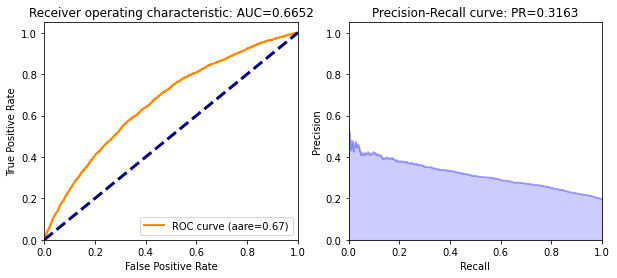

In [69]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
ROC_AUC(glm_gridper3,test_hex,'loan_default')

In [70]:
createGains(glm_gridper3)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,605,995,1600,605,995,0.19,0.08,315.0,1.92,11.0,37.81
1,1600,491,1109,3200,1096,2104,0.35,0.16,630.0,1.74,19.0,34.25
2,1600,409,1191,4800,1505,3295,0.48,0.26,945.0,1.59,22.0,31.35
3,1600,366,1234,6400,1871,4529,0.59,0.35,1260.0,1.48,24.0,29.23
4,1600,315,1285,8000,2186,5814,0.69,0.45,1575.0,1.39,24.0,27.32
5,1600,281,1319,9600,2467,7133,0.78,0.56,1890.0,1.31,22.0,25.70
6,1600,209,1391,11200,2676,8524,0.85,0.66,2205.0,1.21,19.0,23.89
7,1600,177,1423,12800,2853,9947,0.91,0.77,2520.0,1.13,14.0,22.29
8,1600,180,1420,14400,3033,11367,0.96,0.88,2835.0,1.07,8.0,21.06


According to the graph above, we were able to get the AUC on a holdout test set from 63.69% range with the default model to 66.52% range after tuning.

#### [Back to the top](#0)

## 5. Auto Machine Learning<a class="anchor" id="5"></a>
Automated machine learning (AutoML) is the process of applying machine learning (ML) models to real-world problems using automation. More specifically, it automates the selection, composition and parameterization of machine learning models.
### Run AutoML

In [48]:
from h2o.automl import H2OAutoML
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |
09:31:02.437: AutoML: XGBoost is not available; skipping it.
09:31:02.448: _train param, Dropping bad and constant columns: [CR012, TD029, TD028, TD027, TD026, TD025, TD055]

█████
09:31:08.857: _train param, Dropping bad and constant columns: [CR012, TD055]

███
09:31:10.985: _train param, Dropping bad and constant columns: [CR012, TD055]

███
09:31:15.46: _train param, Dropping bad and constant columns: [CR012, TD055]

██
09:31:15.813: _train param, Dropping bad and constant columns: [CR012, TD055]
09:31:16.762: _train param, Dropping bad and constant columns: [CR012, TD055]

█
09:31:17.924: _train param, Dropping bad and constant columns: [CR012, TD055]

██
09:31:18.357: XRT_1_AutoML_1_20221018_93102 [DRF XRT (Extremely Randomized Trees)] failed: java.lang.AssertionError
09:31:18.359: _train param, Dropping bad and constant columns: [CR012, TD055]
09:31:19.10: _train param, Dropping bad and constant columns: [CR012, TD029, TD028, TD027, TD026, TD025, TD055]

█████

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20221018_93102_model_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          15174                  4            4            4             10            16            15.36

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.14266222325764466
RMSE: 0.3777065305996769
LogLoss: 0.4508974510180061
Mean Per-Class Error: 0.3544431494546424
AUC: 0.7010317717910369
AUCPR: 0.3730099377777891
Gini: 0.40206354358207386

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2014374875519918
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      24393  11808  0.3262   (11808.0/36201.0)
1      3302   5326   0.3827   (3302.0/8628.0)
Total  27695  17134  0.3371   (15110.0/44829.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201437     0.413477  232
max f2                       0.134        0.57645   315
max f0point5                 0.288606     0.382447  145
max accuracy                 0.404705     0.812532  71
max precision                0.858729     1         0
max recall                   0.0496147    1         398
max specificity              0.858729     1         0
max absolute_mcc             0.205404     0.236696  228
max min_per_class_accuracy   0.19448      0.645225  240
max mean_per_class_accuracy  0.195495     0.646166  239
max tns                      0.858729     36201     0
max fns                      0.858729     8626      0
max fps                      0.0445439    36201     399
max tps                      0.0496147    8628      398
max tnr                      0.858729     1         0
max fnr                      0.858729     0.999768  0
max fpr                      0.0445439    1         399
max tpr                      0.0496147    1         398

Gains/Lift Table: Avg response rate: 19.25 %, avg score: 19.26 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100158                   0.455026           3.52941   3.52941            0.679287         0.513911   0.679287                    0.513911            0.03535         0.03535                    252.941   252.941            0.0313722
2        0.0200094                   0.416704           2.86463   3.19739            0.551339         0.435036   0.615385                    0.474517            0.0286277       0.0639777                  186.463   219.739            0.0544476
3        0.0300029                   0.390029           2.52829   2.97452            0.486607         0.402445   0.572491                    0.450511            0.0252666       0.0892443                  152.829   197.452            0.0733608
4        0.0400187                   0.373323           2.17551   2.77455            0.418708         0.381141   0.534002                    0.433149            0.0217895       0.111034                   117.551   177.455            0.0879406
5        0.0500123                   0.358133           2.21516   2.66277            0.426339         0.365649   0.5

### Leaderboard

Next, we will view the AutoML Leaderboard.  In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). 

In [49]:
aml_v1.leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_1_20221018_93102_model_2,0.66404,0.463602,0.305302,0.377687,0.38376,0.147272
GLM_1_AutoML_1_20221018_93102,0.663516,0.464552,0.30103,0.376006,0.384239,0.147639
GBM_5_AutoML_1_20221018_93102,0.661771,0.464189,0.302855,0.376149,0.384084,0.147521
GBM_grid_1_AutoML_1_20221018_93102_model_3,0.660735,0.464362,0.304302,0.375572,0.384078,0.147516
GBM_2_AutoML_1_20221018_93102,0.657051,0.465156,0.303805,0.384664,0.384368,0.147739
DeepLearning_1_AutoML_1_20221018_93102,0.656682,0.466363,0.294176,0.381588,0.384706,0.147999
GBM_3_AutoML_1_20221018_93102,0.656055,0.466567,0.298002,0.383004,0.385071,0.148279
GBM_4_AutoML_1_20221018_93102,0.652756,0.468738,0.294455,0.384184,0.386073,0.149052
GBM_1_AutoML_1_20221018_93102,0.652206,0.467462,0.293744,0.385685,0.385566,0.148661
GBM_grid_1_AutoML_1_20221018_93102_model_4,0.63813,0.473855,0.278529,0.3956,0.388265,0.15075


Now we will view a snapshot of the top models. At or near the top of the leaderboard are GBM models with GridSearch. It reaches a AUC of 0.6640. 

### Predict Using Leader Model

To generate predictions on a test set, we can make predictions on the `"H2OAutoML"` object directly, or on the leader model object.

In [50]:
pred = aml_v1.predict(test_hex)
pred.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.859407,0.140593
0,0.849813,0.150187
0,0.900362,0.099638
1,0.79166,0.20834
1,0.544857,0.455143
0,0.844323,0.155677
1,0.611225,0.388775
1,0.726434,0.273566
1,0.80449,0.19551
0,0.838623,0.161377


The standard 'model_performance( )' method can be applied to the AutoML leader model and a test set to generate an H2O model performance object.

In [51]:
perf = aml_v1.leader.model_performance(test_hex)
perf

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14981107748605957
RMSE: 0.38705435985925746
LogLoss: 0.4697482777421151
Mean Per-Class Error: 0.379911061700945
AUC: 0.6653957507257118
AUCPR: 0.312839660872949
Gini: 0.33079150145142355

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20076728123719964
       0     1     Error    Rate
-----  ----  ----  -------  ----------------
0      8520  4330  0.337    (4330.0/12850.0)
1      1332  1818  0.4229   (1332.0/3150.0)
Total  9852  6148  0.3539   (5662.0/16000.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.200767     0.391052  223
max f2                       0.116928     0.567771  335
max f0point5                 0.243264     0.345839  177
max accuracy                 0.508569     0.803125  16
max precision                0.508569     0.5       16
max recall                   0.0591952    1         395
max specificity              0.617576     0.999922  0
max absolute_mcc             0.20905      0.199539  213
max min_per_class_accuracy   0.191407     0.616825  234
max mean_per_class_accuracy  0.200767     0.620089  223
max tns                      0.617576     12849     0
max fns                      0.617576     3150      0
max fps                      0.0454096    12850     399
max tps                      0.0591952    3150      395
max tnr                      0.617576     0.999922  0
max fnr                      0.617576     1         0
max fpr                      0.0454096    1         399
max tpr                      0.0591952    1         395

Gains/Lift Table: Avg response rate: 19.69 %, avg score: 19.23 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.440963           2.22222   2.22222            0.4375           0.485168   0.4375                      0.485168            0.0222222       0.0222222                  122.222   122.222            0.0152183
2        0.02                        0.406094           1.93651   2.07937            0.38125          0.421621   0.409375                    0.453395            0.0193651       0.0415873                  93.6508   107.937            0.0268791
3        0.03                        0.385431           2.31746   2.15873            0.45625          0.395041   0.425                       0.433943            0.0231746       0.0647619                  131.746   115.873            0.0432833
4        0.04                        0.37026            1.80952   2.07143            0.35625          0.377578   0.407813                    0.419852            0.0180952       0.0828571                  80.9524   107.143            0.053363
5        0.05                        0.357056           1.77778   2.0127             0.35             0.363088   0.39625                     0.408499            0.0177778       0.100635                   77.7778   101.27             0.0630474
6        0.1                         0.309146           1.82222   1.91746            0.35875          0.33137    0.3775                      0.369935            0.0911111       0.191746                   82.2222   91.746             0.114236
7        0.15                        0.279958           1.64444   1.82646            0.32375          0.293883   0.359583                    0.344584            0.0822222       0.273968                   64.4444   82.6455            0.154357
8        0.2       

In [52]:
createGains(aml_v1)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,1600,604,996,1600,604,996,0.19,0.08,315.0,1.92,11.0,37.75
1,1600,488,1112,3200,1092,2108,0.35,0.16,630.0,1.73,19.0,34.12
2,1600,423,1177,4800,1515,3285,0.48,0.26,945.0,1.60,22.0,31.56
3,1600,344,1256,6400,1859,4541,0.59,0.35,1260.0,1.48,24.0,29.05
4,1600,300,1300,8000,2159,5841,0.69,0.45,1575.0,1.37,24.0,26.99
5,1600,292,1308,9600,2451,7149,0.78,0.56,1890.0,1.30,22.0,25.53
6,1600,231,1369,11200,2682,8518,0.85,0.66,2205.0,1.22,19.0,23.95
7,1600,200,1400,12800,2882,9918,0.91,0.77,2520.0,1.14,14.0,22.52
8,1600,158,1442,14400,3040,11360,0.97,0.88,2835.0,1.07,9.0,21.11


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



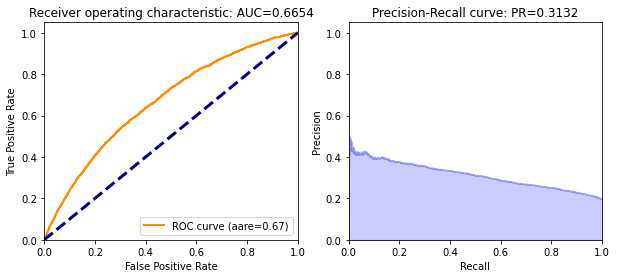

In [71]:
ROC_AUC(aml_v1,test_hex,'loan_default')

The AUC of the best model of AutoML on the test dataset is 0.6654. That is to say, there is 66.54% chance for the model to identify the loan fault class and the normal class.

## 6. Conclusion <a class="anchor" id="6"></a>
In this report, we use GLM and Auto Machine Learning to train machine learning models on the mortgage probability of default data.

We first train a GLM model and then tune the hyper-parameters with grid search. The best model has a alpha value of 0.1 and lambda of 0.01,, and reach a AUC of 0.6652. That means there is a 66.52% chance that the model will be able to distinguish between loan default class and the normal class.

We then run AutoML where stopping is based on max number of models and view the leaderboard (based on cross-validation metrics), looking for the model with the max AUC score for the test set. The best model achieves an AUC score for the test data was 0.6654. That is to say, there is a 66.54% chance that the model will be able to distinguish between loan default class and the normal class.

### Reference
 - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html#elastic-net-penalty
 - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/alpha.html
 - https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
 - https://github.com/h2oai/h2o-tutorials/blob/master/h2o-world-2017/automl/Python/automl_binary_classification_product_backorders.ipynb

#### [Back to the top](#0)